<a href="https://colab.research.google.com/github/AbdollahMasoud/IJCNN-2023/blob/main/IJCNN_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Get Data from Repo
!git clone 'https://github.com/AbdollahMasoud/IJCNN-2023'

Cloning into 'IJCNN-2023'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 24 (delta 8), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (24/24), 11.78 MiB | 5.85 MiB/s, done.


In [ ]:
# Extract Image Folders
!unzip 'IJCNN-2023/Dataset.zip' -d '/content/'

In [3]:
# Adding Preliminaries

!pip install catboost

import gc
import os
import cv2
import time
import imutils
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import catboost as ctb
from imutils import paths
from statistics import mean 
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from datetime import datetime as dt
from sklearn.decomposition import PCA
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 8.3 MB/s eta 0:00:00


In [4]:
# Reading FRI Images
imagePaths = list(paths.list_images(r"/content/FRI"))

data = []
labels = []

for imagePath in imagePaths:
  image = cv2.imread(imagePath,cv2.IMREAD_GRAYSCALE)
  image = image[124:174,124:174]
  data.append(image)
  label = 1
  labels.append(label)
print("Loaded FRI...")

Loaded FRI...


In [5]:
# Reading FRII Images
imagePaths = list(paths.list_images(r"/content/FRII"))

for imagePath in imagePaths:
  image = cv2.imread(imagePath,cv2.IMREAD_GRAYSCALE)
  image = image[124:174,124:174]
  data.append(image)
  label = 2
  labels.append(label)
print("Loaded FRII...")

Loaded FRII...


In [6]:
# Reading FR0 Images  
imagePaths = list(paths.list_images(r"/content/FR0"))

for imagePath in imagePaths:
  image = cv2.imread(imagePath,cv2.IMREAD_GRAYSCALE)
  image = image[124:174,124:174]
  data.append(image)
  label = 0
  labels.append(label)
print("Loaded FR0...")

Loaded FR0...


In [7]:
labels = np.array(labels,dtype='uint8')
data = np.array(data,dtype='uint8')

# Flatten Images
data = data.reshape((len(data),50*50))
data = pd.DataFrame(data)
labels = pd.DataFrame(labels)
BB = pd.concat([data,labels], axis=1)
FRI = BB[0:5008]
FRII = BB[5008:7074]
FR0 = BB[7074::] 

In [8]:

# Choose Number of Samples per Class ; Max is 2000 for a Balanced Dataset
samplesize=2000

# Balancing the Dataset
FRI_s = FRI.sample(n=samplesize,random_state=42)
FRII_s = FRII.sample(n=samplesize,random_state=42)
FR0_s = FR0.sample(n=samplesize,random_state=42)
Images_s = pd.concat([FRI_s,FRII_s,FR0_s])
Images_s = shuffle(Images_s,random_state=42)
lbl = Images_s.iloc[:,-1:]
Imgs = Images_s.iloc[:,:-1]

# Using PCA
pca_fit = PCA(n_components=34)
Imgs=pca_fit.fit_transform(Imgs)
Imgs = np.array(Imgs)
lbl = np.array(lbl)

ConfMat_CAT = []
TTrain_CAT = []
TTest_CAT = []
ConfMat_LGB = []
TTrain_LGB = []
TTest_LGB = []
ConfMat_XGB = []
TTrain_XGB = []
TTest_XGB = []

# Setting up Repeated K Fold
kf = RepeatedKFold(n_splits=5,n_repeats=10,random_state=42)

count=0

for train_index, test_index in kf.split(Imgs):
  trainX, testX = Imgs[train_index], Imgs[test_index]
  trainY, testY = lbl[train_index], lbl[test_index]

  trainX = np.array(trainX)
  testX = np.array(testX)
  trainY = np.array(trainY)
  testY = np.array(testY)
  
  # Train & Test CatBoost Classifier
  # boosting_type='Ordered' is slow ; For faster execution consider using boosting_type='Plain'
  clf = ctb.CatBoostClassifier(logging_level='Silent',classes_count=3,boosting_type='Ordered',learning_rate=0.1,l2_leaf_reg=3,max_depth=6,loss_function='MultiClass')
  start = dt.now()
  clf.fit(trainX,trainY.ravel())
  time = (dt.now() - start).total_seconds()
  TTrain_CAT.append(time)
  start = dt.now()
  predY=clf.predict(testX)
  time = (dt.now() - start).total_seconds()
  TTest_CAT.append(time)
  ConfMat=confusion_matrix(testY,predY)
  ConfMat_CAT.append(ConfMat)

  # Train & Test LightGBM Classifier
  clf = lgb.LGBMClassifier(objective='multiclass',num_class=3)
  start = dt.now()
  clf.fit(trainX,trainY.ravel())
  time = (dt.now() - start).total_seconds()
  TTrain_LGB.append(time)
  start = dt.now()
  predY=clf.predict(testX)
  time = (dt.now() - start).total_seconds()
  TTest_LGB.append(time)
  ConfMat=confusion_matrix(testY,predY)
  ConfMat_LGB.append(ConfMat)

  # Train & Test XGB Classifier
  clf = xgb.XGBClassifier(booster='gbtree',objective='multi:softmax',num_class=3,learning_rate=0.3,gamma=0,max_depth=9)
  start = dt.now()
  clf.fit(trainX,trainY.ravel())
  time = (dt.now() - start).total_seconds()
  TTrain_XGB.append(time)
  start = dt.now()
  predY=clf.predict(testX)
  time = (dt.now() - start).total_seconds()
  TTest_XGB.append(time)
  ConfMat=confusion_matrix(testY,predY)
  ConfMat_XGB.append(ConfMat)

  count+=1
  print(count,'/','50 Iterations Done')

1 / 50 Iterations Done
2 / 50 Iterations Done
3 / 50 Iterations Done
4 / 50 Iterations Done
5 / 50 Iterations Done
6 / 50 Iterations Done
7 / 50 Iterations Done
8 / 50 Iterations Done
9 / 50 Iterations Done
10 / 50 Iterations Done
11 / 50 Iterations Done
12 / 50 Iterations Done
13 / 50 Iterations Done
14 / 50 Iterations Done
15 / 50 Iterations Done
16 / 50 Iterations Done
17 / 50 Iterations Done
18 / 50 Iterations Done
19 / 50 Iterations Done
20 / 50 Iterations Done
21 / 50 Iterations Done
22 / 50 Iterations Done
23 / 50 Iterations Done
24 / 50 Iterations Done
25 / 50 Iterations Done
26 / 50 Iterations Done
27 / 50 Iterations Done
28 / 50 Iterations Done
29 / 50 Iterations Done
30 / 50 Iterations Done
31 / 50 Iterations Done
32 / 50 Iterations Done
33 / 50 Iterations Done
34 / 50 Iterations Done
35 / 50 Iterations Done
36 / 50 Iterations Done
37 / 50 Iterations Done
38 / 50 Iterations Done
39 / 50 Iterations Done
40 / 50 Iterations Done
41 / 50 Iterations Done
42 / 50 Iterations Done
4



CAT Confusion Matrix:
[[17566  1736   698]
 [ 2179 15363  2458]
 [  973  2445 16582]]


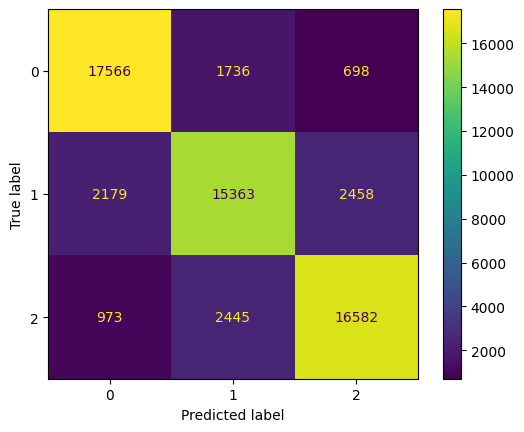


CAT Performance:
CAT Accuracy: 0.8251833333333334
CAT Precision FR0: 0.8478617627184091
CAT Precision FRI: 0.7860724519033975
CAT Precision FRII: 0.8401053804843449
CAT Recall FR0: 0.8783
CAT Recall FRI: 0.76815
CAT Recall FRII: 0.8291
CAT F1 FR0: 0.8628125153494768
CAT F1 FRI: 0.7770078899453773
CAT F1 FRII: 0.8345664099854044
CAT Training Time: 135.16523924
CAT Testing Time: 0.02076784


LGB Confusion Matrix:
[[17439  1900   661]
 [ 2215 15254  2531]
 [ 1015  2491 16494]]


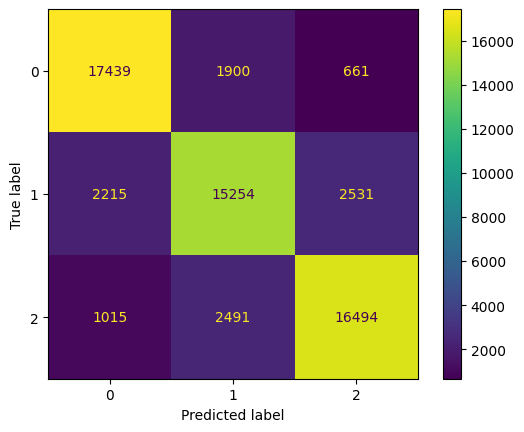


LGB Performance:
LGB Accuracy: 0.8197833333333333
LGB Precision FR0: 0.843727321108907
LGB Precision FRI: 0.7764825655383049
LGB Precision FRII: 0.8378543127095398
LGB Recall FR0: 0.87195
LGB Recall FRI: 0.7627
LGB Recall FRII: 0.8247
LGB F1 FR0: 0.8576065307728246
LGB F1 FRI: 0.7695295749779291
LGB F1 FRII: 0.8312251171697829
LGB Training Time: 1.8869928200000001
LGB Testing Time: 0.02363082


XGB Confusion Matrix:
[[17385  1925   690]
 [ 2156 15321  2523]
 [ 1017  2561 16422]]


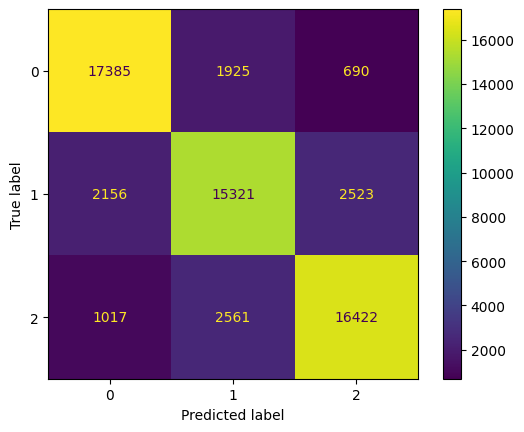


XGB Performance:
XGB Accuracy: 0.8188
XGB Precision FR0: 0.8456561922365989
XGB Precision FRI: 0.7735144140960266
XGB Precision FRII: 0.8363636363636363
XGB Recall FR0: 0.86925
XGB Recall FRI: 0.76605
XGB Recall FRII: 0.8211
XGB F1 FR0: 0.8572907934316287
XGB F1 FRI: 0.7697641118396261
XGB F1 FRII: 0.8286615365207518
XGB Training Time: 14.14074582
XGB Testing Time: 0.01574426


In [9]:
# Plotting and Displaying Results

CAT=np.sum(ConfMat_CAT,axis = 0)
print("\n\nCAT Confusion Matrix:")
print(CAT)
disp = ConfusionMatrixDisplay(confusion_matrix=CAT, display_labels=clf.classes_)
disp.plot()
plt.show()
APR=CAT
CAT_acc=(APR[0,0]+APR[1,1]+APR[2,2])/np.sum(APR)
CAT_FR0_P=APR[0,0]/sum(APR[:,0])
CAT_FR1_P=APR[1,1]/sum(APR[:,1])
CAT_FR2_P=APR[2,2]/sum(APR[:,2])
CAT_FR0_R=APR[0,0]/sum(APR[0,:])
CAT_FR1_R=APR[1,1]/sum(APR[1,:])
CAT_FR2_R=APR[2,2]/sum(APR[2,:])
CAT_FR0_F1=2*(CAT_FR0_P*CAT_FR0_R)/(CAT_FR0_P+CAT_FR0_R)
CAT_FR1_F1=2*(CAT_FR1_P*CAT_FR1_R)/(CAT_FR1_P+CAT_FR1_R)
CAT_FR2_F1=2*(CAT_FR2_P*CAT_FR2_R)/(CAT_FR2_P+CAT_FR2_R)
print("\nCAT Performance:")
print("CAT Accuracy: " + str(CAT_acc))
print("CAT Precision FR0: " + str(CAT_FR0_P))
print("CAT Precision FRI: " + str(CAT_FR1_P))
print("CAT Precision FRII: " + str(CAT_FR2_P))
print("CAT Recall FR0: " + str(CAT_FR0_R))
print("CAT Recall FRI: " + str(CAT_FR1_R))
print("CAT Recall FRII: " + str(CAT_FR2_R))
print("CAT F1 FR0: " + str(CAT_FR0_F1))
print("CAT F1 FRI: " + str(CAT_FR1_F1))
print("CAT F1 FRII: " + str(CAT_FR2_F1))
print("CAT Training Time: " + str(mean(TTrain_CAT)))
print("CAT Testing Time: " + str(mean(TTest_CAT)))

LGB=np.sum(ConfMat_LGB,axis = 0)
print("\n\nLGB Confusion Matrix:")
print(LGB)
disp = ConfusionMatrixDisplay(confusion_matrix=LGB, display_labels=clf.classes_)
disp.plot()
plt.show()
APR=LGB
LGB_acc=(APR[0,0]+APR[1,1]+APR[2,2])/np.sum(APR)
LGB_FR0_P=APR[0,0]/sum(APR[:,0])
LGB_FR1_P=APR[1,1]/sum(APR[:,1])
LGB_FR2_P=APR[2,2]/sum(APR[:,2])
LGB_FR0_R=APR[0,0]/sum(APR[0,:])
LGB_FR1_R=APR[1,1]/sum(APR[1,:])
LGB_FR2_R=APR[2,2]/sum(APR[2,:])
LGB_FR0_F1=2*(LGB_FR0_P*LGB_FR0_R)/(LGB_FR0_P+LGB_FR0_R)
LGB_FR1_F1=2*(LGB_FR1_P*LGB_FR1_R)/(LGB_FR1_P+LGB_FR1_R)
LGB_FR2_F1=2*(LGB_FR2_P*LGB_FR2_R)/(LGB_FR2_P+LGB_FR2_R)
print("\nLGB Performance:")
print("LGB Accuracy: " + str(LGB_acc))
print("LGB Precision FR0: " + str(LGB_FR0_P))
print("LGB Precision FRI: " + str(LGB_FR1_P))
print("LGB Precision FRII: " + str(LGB_FR2_P))
print("LGB Recall FR0: " + str(LGB_FR0_R))
print("LGB Recall FRI: " + str(LGB_FR1_R))
print("LGB Recall FRII: " + str(LGB_FR2_R))
print("LGB F1 FR0: " + str(LGB_FR0_F1))
print("LGB F1 FRI: " + str(LGB_FR1_F1))
print("LGB F1 FRII: " + str(LGB_FR2_F1))
print("LGB Training Time: " + str(mean(TTrain_LGB)))
print("LGB Testing Time: " + str(mean(TTest_LGB)))

XGB=np.sum(ConfMat_XGB,axis = 0)
print("\n\nXGB Confusion Matrix:")
print(XGB)
disp = ConfusionMatrixDisplay(confusion_matrix=XGB, display_labels=clf.classes_)
disp.plot()
plt.show()
APR=XGB
XGB_acc=(APR[0,0]+APR[1,1]+APR[2,2])/np.sum(APR)
XGB_FR0_P=APR[0,0]/sum(APR[:,0])
XGB_FR1_P=APR[1,1]/sum(APR[:,1])
XGB_FR2_P=APR[2,2]/sum(APR[:,2])
XGB_FR0_R=APR[0,0]/sum(APR[0,:])
XGB_FR1_R=APR[1,1]/sum(APR[1,:])
XGB_FR2_R=APR[2,2]/sum(APR[2,:])
XGB_FR0_F1=2*(XGB_FR0_P*XGB_FR0_R)/(XGB_FR0_P+XGB_FR0_R)
XGB_FR1_F1=2*(XGB_FR1_P*XGB_FR1_R)/(XGB_FR1_P+XGB_FR1_R)
XGB_FR2_F1=2*(XGB_FR2_P*XGB_FR2_R)/(XGB_FR2_P+XGB_FR2_R)
print("\nXGB Performance:")
print("XGB Accuracy: " + str(XGB_acc))
print("XGB Precision FR0: " + str(XGB_FR0_P))
print("XGB Precision FRI: " + str(XGB_FR1_P))
print("XGB Precision FRII: " + str(XGB_FR2_P))
print("XGB Recall FR0: " + str(XGB_FR0_R))
print("XGB Recall FRI: " + str(XGB_FR1_R))
print("XGB Recall FRII: " + str(XGB_FR2_R))
print("XGB F1 FR0: " + str(XGB_FR0_F1))
print("XGB F1 FRI: " + str(XGB_FR1_F1))
print("XGB F1 FRII: " + str(XGB_FR2_F1))
print("XGB Training Time: " + str(mean(TTrain_XGB)))
print("XGB Testing Time: " + str(mean(TTest_XGB)))